In [1]:
import pandas as pd
import talib as ta
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans 

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import warnings
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)  # 设置 matplotlib 日志级别为 WARNING
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

matplotlib.rcParams['font.family']= ['Songti SC']  # 使用黑体-简
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [2]:
df = pd.read_csv('../data/stock.csv', parse_dates=True)

df.head()

,date,open,close,low,high,volume,count,amount
0,2017-10-26 12:00:00,230.00,296.67,230.00,299.40,148701.673027,52,575.1466
1,2017-10-26 12:30:00,296.28,290.00,290.00,296.68,164207.334934,48,557.3589
2,2017-10-26 13:00:00,291.43,292.69,289.01,294.00,448773.263215,49,1541.4099
3,2017-10-26 13:30:00,290.29,294.07,290.29,296.36,405905.625453,43,1379.0684
4,2017-10-26 14:00:00,293.65,292.30,292.00,293.65,317590.616442,43,1085.3961


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


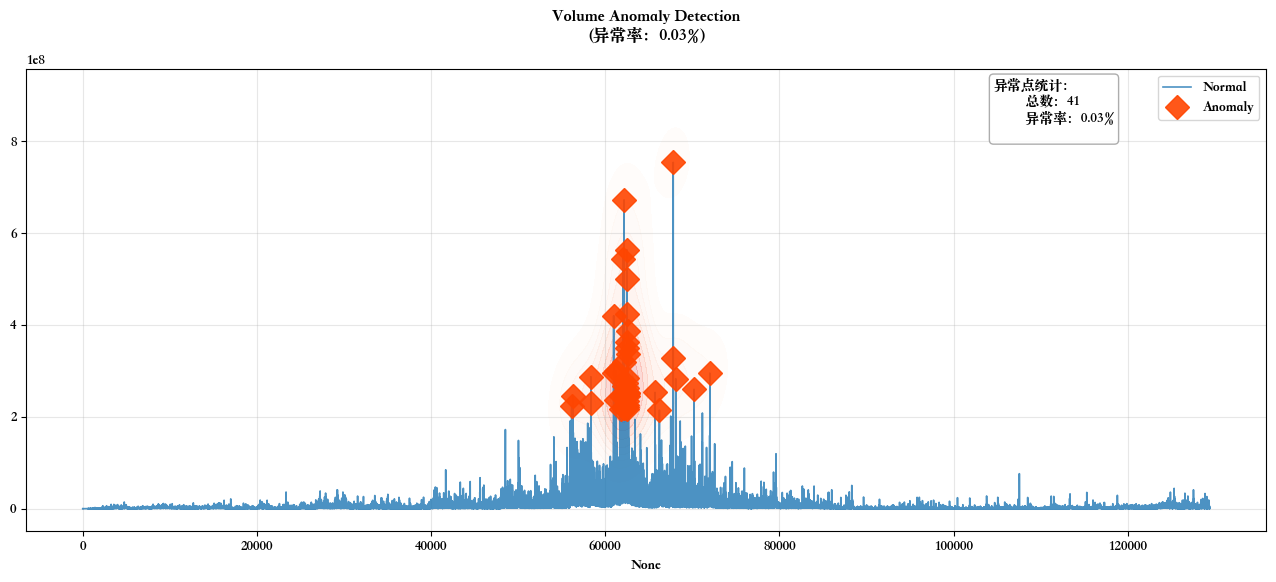

/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_79090/3619056312.py:54: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.loc[iso_forest_anomalies] = df.loc[iso_forest_anomalies].interpolate() # 使用线性插值填充异常值


In [3]:
def iso_forest_detect(series):
    model = IsolationForest(
        contamination=0.0005,  # 预期异常比例
        random_state=42
    )
    X = series.values.reshape(-1,1)
    return model.fit_predict(X) == -1
def plot_anomalies(series, anomalies, title):
    plt.figure(figsize=(16, 6))
    # 主序列
    ax = series.plot(label='Normal', alpha=0.8,linewidth=1.2)
    
    # 异常点（确保索引对齐）
    anomaly_points = series.loc[anomalies]
    anomaly_points.plot(
        ax=ax,
        style='D',
        markersize=12,
        color='#FF4500',  # 使用更醒目的橙色
        label='Anomaly',
        alpha=0.9
    )
    # 添加异常密度热力图
    if len(anomaly_points) > 0:
        sns.kdeplot(
            x=anomaly_points.index.astype(np.int64), 
            y=anomaly_points.values,
            cmap='Reds',
            fill=True,
            alpha=0.2,
            ax=ax
        )
    plt.title(f'{title} Anomaly Detection\n(异常率：{anomalies.mean():.2%})', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 添加统计信息框
    stats_text = f"""异常点统计：
    • 总数：{anomalies.sum()}
    • 异常率：{anomalies.mean():.2%}
    """
    
    plt.annotate(stats_text, 
                xy=(0.78, 0.85), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    plt.show()
iso_forest_anomalies = iso_forest_detect(df['volume'])

plot_anomalies(df['volume'], iso_forest_anomalies, 'Volume')


df.loc[iso_forest_anomalies]=np.nan
df.loc[iso_forest_anomalies] = df.loc[iso_forest_anomalies].interpolate() # 使用线性插值填充异常值

In [4]:
def create_features(data:pd.DataFrame):
    data['EMA20'] = ta.EMA(data['close'], timeperiod=20)
    data['EMA100'] = ta.EMA(data['close'], timeperiod=100)
    data['SMA20'] = ta.SMA(data['close'], timeperiod=20)
    data['SMA100'] = ta.SMA(data['close'], timeperiod=100)

    data['RSI'] = ta.RSI(data['close'], timeperiod=14)
    # 平均真实波幅
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=14)
    # 波动率
    data['Volatility'] = data['ATR'] / data['close']
    data['MACD'], data['Signal'], data['Hist'] = ta.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    # MACD线瞬时斜率
    data['macd_slope'] = data['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        data[f'macd_slope_ma{window}'] = data['macd_slope'].rolling(window).mean()
    
    # 计算价格波动率
    # 对数收益率滚动标准差
    data['close_volatility'] = np.log(data['close'] / data['close'].shift(1))
    data['Volatility_10'] = data['close_volatility'].rolling(window=10).std() * np.sqrt(10)
    data['close_Volume_volatility'] = data['close_volatility'] * data['volume']
    data['Volume_volatility_10'] = data['close_Volume_volatility'].rolling(window=10).std() * np.sqrt(10)
    # 计算布林带
    data['UpperBB'],data['MiddleBB'],data['LowerBB'] = ta.BBANDS(data['close'], timeperiod=20)

    # 特征工程
    for lag in [1, 3, 5]:
        data[f'return_lag{lag}'] = data['close'].pct_change(lag)
    # # 计算趋势线
    # seasonal_decompose = sm.tsa.seasonal_decompose(data['close'], model='additive', period=96) 
    # data['trend'] = seasonal_decompose.trend
    # data['seasonal'] = seasonal_decompose.seasonal
    # data['residual'] = seasonal_decompose.resid
    return df.dropna()

def create_(data:pd.DataFrame):
    data[['final_peak', 'final_valley']].fillna(value=False)
    df['bottom_divergence'] = (df['final_valley'] == 1 & (df['macd_slope_ma3'] > 0)).astype(int)
    
    df['top_divergence'] = (df['final_peak'] == 1 & 
                                (df['macd_slope_ma3'] < 0)).astype(int)
    
    
    

In [5]:
df = create_features(df)

df.to_csv("../data/train.csv", index=False)

df.tail()

/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_79090/3939228687.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'return_lag{lag}'] = data['close'].pct_change(lag)
/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_79090/3939228687.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'return_lag{lag}'] = data['close'].pct_change(lag)
/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_79090/3939228687.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-lea

,date,open,close,low,high,volume,count,amount,EMA20,EMA100,...,close_volatility,Volatility_10,close_Volume_volatility,Volume_volatility_10,UpperBB,MiddleBB,LowerBB,return_lag1,return_lag3,return_lag5
56136,2021-01-08 00:00:00,1249.68,1270.03,1238.63,1275.00,1.519157e+08,88764.0,120707.615800,1217.252295,1150.555278,...,0.016153,0.028735,2.453894e+06,2.586650e+06,1254.853740,1209.1415,1163.429260,0.016284,0.037844,0.042718
56137,2021-01-08 00:30:00,1270.03,1264.00,1256.54,1276.77,4.554146e+07,38376.0,35921.204872,1221.704458,1152.801708,...,-0.004759,0.030461,-2.167421e+05,2.671521e+06,1263.660887,1212.4120,1161.163113,-0.004748,0.035217,0.033575
56138,2021-01-08 01:00:00,1264.01,1271.01,1258.87,1272.67,2.763913e+07,25636.0,21843.700586,1226.400224,1155.142467,...,0.005531,0.029678,1.528600e+05,2.677215e+06,1272.765864,1216.1435,1159.521136,0.005546,0.017068,0.038644
56139,2021-01-08 01:30:00,1271.01,1270.57,1262.04,1273.71,1.671641e+07,18281.0,13184.631076,1230.606869,1157.428160,...,-0.000346,0.029463,-5.787913e+03,2.705898e+06,1279.915025,1220.3715,1160.827975,-0.000346,0.000425,0.040598
56140,2021-01-08 02:00:00,1270.56,1248.21,1227.17,1288.88,1.103349e+08,77906.0,87642.332626,1232.283358,1159.225821,...,-0.017755,0.036254,-1.959007e+06,3.561666e+06,1281.238661,1223.8910,1166.543339,-0.017598,-0.012492,-0.001176
